# Image Classification Local Notebook

***Supervised Learning with TensorFlow Keras: Image Classification on CIFAR-10 Dataset***

This notebook works well with `Python 3 (TensorFlow 2.3 Python 3.7 CPU Optimized)` or `Python 3 (Tensorflow 2.3 Python 3.7 GPU Optimized)` kernel on SageMaker Studio, or Jupyter notebook kernel with TensorFlow >=v2.3 notebook environment.

---
---

Contents:
1. [Objective](objective)
2. [Background](background)
3. [Environment Setup](environment-setup)
4. [Data Preparation](data-augmentation)
5. [Testing Harness](testing-harness)
6. [Model Training](model-training)

---

## Objective

The purpose of the lab is to demonstrate how to train Image Classification model under local notebook environment, especially, when running the notebook in SageMaker Studio environment.

Teaching in-depth deep learning approaches with TensorFlow Keras is outside this scope, and we hope that you may reuse the notebook to fast experiment your model backed by local compute resources for your future projects.

## Background

To do image classification to identify objects like airplane, automobile, bird, cat, deer, dog, frog, horse, ship and trunk. We shall use Deep Learning framework TensorFlow to train a CNN model backed by [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). 

CIFAR is an acronym that stands for the [Canadian Institute For Advanced Research](https://cifar.ca/) and the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) was developed along with the CIFAR-100 dataset by researhers at the CIFAR instite.

For [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), it consists of 60,000 32x32 pixel color pictures of objects from 10 classes, such as bird, cat and deer, etc. The class labels and their standard associated integer values are listed below:

* 0: airplane
* 1: automobile
* 2: bird
* 3: cat
* 4: deer
* 5: dog
* 6: frog
* 7: horse
* 8: ship
* 9: truck


## Environment Setup

We shall use CIFAR10 dataset from AWS Open Data - [Image classification - fast.ai datasets](https://registry.opendata.aws/fast-ai-imageclas/). Below are the step to setup the notebook running environment.

***Please wait until the below cell execution done and kernel restarted***

In [ ]:
import sys
import IPython

!{sys.executable} -m pip install --upgrade pip --user
!{sys.executable} -m pip install matplotlib ipywidgets opencv-python seaborn sklearn --user

IPython.Application.instance().kernel.do_shutdown(True)

In [3]:
import os
import random

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## Data Preparation

We shall download CIFAR10 dataset to local `/tmp/data` folder. 

In [4]:
data_folder = '/tmp/data'

train_data_dir = f'{data_folder}/cifar10/train'
test_data_dir = f'{data_folder}/cifar10/test'

In [ ]:
%%sh 


mkdir -p $data_folder

aws s3 cp --no-sign-request s3://fast-ai-imageclas/cifar10.tgz $data_folder
    
ls -l $data_folder/cifar10.tgz

tar -zxvf $data_folder/cifar10.tgz -C $data_folder

In [5]:
class_names = [
    'airplane',
    'automobile', 
    'bird',
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (32, 32)

In [6]:
from PIL import Image

def get_image_array(image_path):
    img = Image.open(image_path, 'r')
    return np.array(img)

def display_examples(class_names, dataset_folder):
    fig = plt.figure(figsize = (10, 10))
    fig.suptitle('Some examples of images of the dataset', fontsize = 16)
    
    for i in range(20):
        image_class = class_names[random.randint(0, len(class_names) - 1)]
        image_folder = f'{dataset_folder}/{image_class}'
        image_files = os.listdir(image_folder)
        image_file = image_files[random.randint(0, len(image_files) - 1)]
        image_file_path = f'{image_folder}/{image_file}'
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(get_image_array(image_file_path))
        plt.xlabel(image_class)
    plt.show()

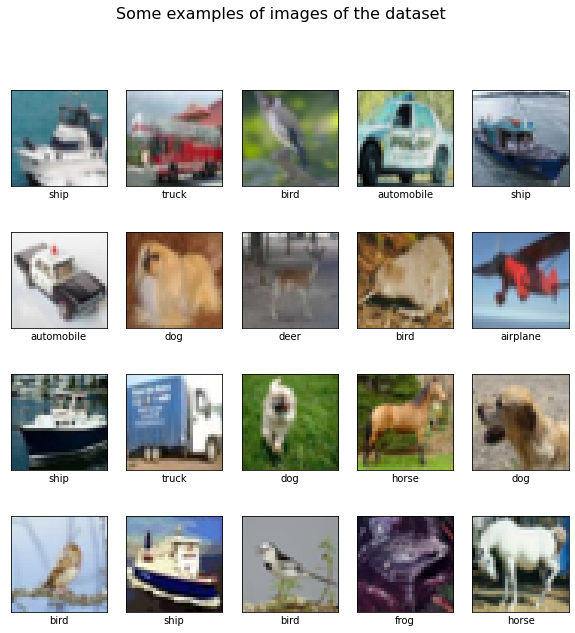

In [7]:
display_examples(class_names, train_data_dir)

### Data Augmentation
Image augmentation applies transforms to an image and results in additional images that the network can train on. Image data generator has many options and also allows custom preprocessing functions through the parameter of the same name.

In [61]:
tf.random.set_seed(99)

def blur_preprocessing(img):
    return cv2.blur(img, (5, 5))

# training data generator; commented parameters are not needed after evaluated the validation dataset.
train_data_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0, 
    validation_split = 0.0, # it's for training dataset only
#     rotation_range = 30,
    shear_range = 0.2,
    zoom_range =0.2,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
    horizontal_flip = True,
#     vertical_flip = False,
#     brightness_range = [0.5, 1.5],
#     fill_mode = 'nearest',
#     preprocessing_function = blur_preprocessing
)

# training dataset
train_data_multi = train_data_generator.flow_from_directory(
    directory = train_data_dir,
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42
)

# testing data generator
validation_data_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0
)

# testing dataset
validation_data_multi = validation_data_generator.flow_from_directory(
    directory = test_data_dir,
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42
)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [62]:
train_data_multi.class_indices, validation_data_multi.class_indices

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

In [63]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation = 'softmax')
])

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    mode = 'min',
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience = 2, mode = 'min', verbose=1)

In [66]:
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0001, decay=1e-6)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [67]:
%%time 

history = model.fit(
    train_data_multi, 
    batch_size = 32,
    epochs = 100,
    validation_data = validation_data_multi,
    verbose = 2,
    callbacks = [early_stopping, reduce_lr]
)

Epoch 1/100
1563/1563 - 37s - loss: 1.9523 - accuracy: 0.2786 - val_loss: 1.6996 - val_accuracy: 0.3851
Epoch 2/100
1563/1563 - 37s - loss: 1.7273 - accuracy: 0.3673 - val_loss: 1.5766 - val_accuracy: 0.4286
Epoch 3/100
1563/1563 - 37s - loss: 1.6257 - accuracy: 0.4035 - val_loss: 1.4232 - val_accuracy: 0.4769
Epoch 4/100
1563/1563 - 37s - loss: 1.5515 - accuracy: 0.4344 - val_loss: 1.3673 - val_accuracy: 0.4966
Epoch 5/100
1563/1563 - 37s - loss: 1.4933 - accuracy: 0.4597 - val_loss: 1.2996 - val_accuracy: 0.5282
Epoch 6/100
1563/1563 - 37s - loss: 1.4382 - accuracy: 0.4810 - val_loss: 1.3210 - val_accuracy: 0.5217
Epoch 7/100
1563/1563 - 37s - loss: 1.3964 - accuracy: 0.4962 - val_loss: 1.2410 - val_accuracy: 0.5535
Epoch 8/100
1563/1563 - 37s - loss: 1.3594 - accuracy: 0.5104 - val_loss: 1.4286 - val_accuracy: 0.5027
Epoch 9/100
1563/1563 - 37s - loss: 1.3279 - accuracy: 0.5235 - val_loss: 1.3111 - val_accuracy: 0.5415
Epoch 10/100
1563/1563 - 37s - loss: 1.2940 - accuracy: 0.5374 -

### Evaluate the model

Evaluate the model training process.

In [68]:
def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc = 'upper left')
    
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc = 'upper left')
    plt.show()

In [92]:
metric_names = list(history.history)


In [93]:
history.history['val_loss'][-1], history.history['val_accuracy'][-1]

(0.8691892623901367, 0.6995999813079834)

In [94]:
print(
        "Validation results: "
        + "; ".join(map(
            lambda i: f"{metric_names[i]}={history.history[metric_names[i]][-1]:.5f}", range(len(metric_names))
        ))
    )

Validation results: loss=0.97792; accuracy=0.66220; val_loss=0.86919; val_accuracy=0.69960; lr=0.00000


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


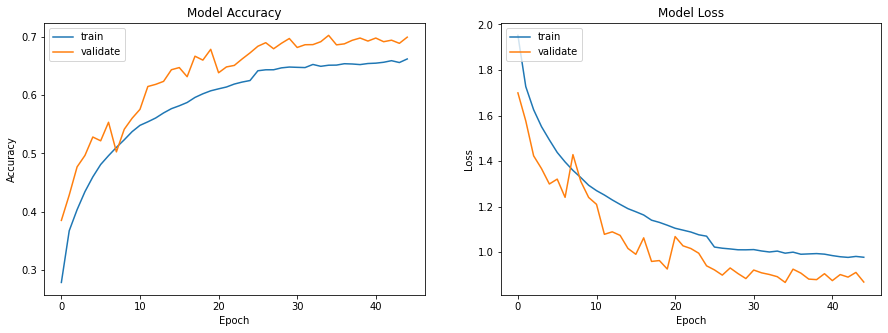

In [69]:
print(history.history.keys())

plot_model_history(history)

### Score trained model and prediction

In [70]:
# score trained model
scores = model.evaluate()

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

In [72]:
image = cv2.imread("./cat.png", 1)

# resize, as our model is expecting images in 32x32.
image = cv2.resize(image, (32, 32))
image = image / 255.0

image = np.expand_dims(image, axis = 0)

In [73]:
pred = model.predict(image)

In [74]:
pred

array([[0.07936735, 0.05063814, 0.08201773, 0.11362453, 0.18626034,
        0.04213552, 0.0780686 , 0.05296266, 0.21162245, 0.10330269]],
      dtype=float32)

In [75]:
np.argmax(pred)

8